# <font color="#154360"><center>Projet 6 : Réalisez une analyse de sentiments grâce au Deep Learning</center></font>
# <font color="#154360"><center>Partie III - Modèles prédictifs avancés avec régression logistique</center></font>

## Préambule 
### 1 - Contexte



### 2 - Chargement des librairies

In [1]:
# Version Python
!python --version

Python 3.12.3


In [79]:
# Librairies pour la manipulation de données
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold, decomposition, cluster, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
import gensim
from gensim.models import FastText
import transformers
from transformers import AutoTokenizer, TFAutoModel
import mlflow
from mlflow.models import infer_signature
from concurrent.futures import ThreadPoolExecutor
from joblib import dump, load
import os

# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# Librairies pour la visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Version bibliothèque partiellement importée
import importlib.metadata

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))
print("matplotlib - ", importlib.metadata.version('matplotlib'))

json - 2.0.9
numpy - 1.26.4
pandas - 2.2.2
tensorflow - 2.18.0
keras - 3.6.0
ipywidgets - 7.8.1
xarray - 2023.6.0
numpy - 1.26.4
pandas - 2.2.2
tensorflow_hub - 0.16.1
tensorflow - 2.18.0
tensorflow - 2.18.0
gensim - 4.3.3
transformers - 4.46.2
mlflow - 2.18.0
seaborn - 0.13.2
matplotlib -  3.9.2


In [3]:
print("GPU disponible : ", tf.config.list_physical_devices('GPU'))

GPU disponible :  []


### 3 - Lecture des fichiers

In [4]:
# Lecture des données textuelles
df_tweet_preproc = pd.read_csv('tweet_preproc.csv', encoding="ISO-8859-1")

In [5]:
df_tweet_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596630 entries, 0 to 1596629
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   sentiment        1596630 non-null  object
 1   id               1596630 non-null  int64 
 2   date             1596630 non-null  object
 3   auteur           1596630 non-null  object
 4   tweet            1588667 non-null  object
 5   long_tweet       1596630 non-null  int64 
 6   label sentiment  1596630 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 85.3+ MB


On constate que des tweets sont vides, nous allons donc les supprimer.

In [6]:
# Supprimer les lignes où 'tweet' est vide ou constitué uniquement d'espaces
df_tweet_preproc = df_tweet_preproc[~df_tweet_preproc['tweet'].isnull() & (df_tweet_preproc['tweet'].str.strip() != '')]

# Réinitialiser les index après suppression des lignes
df_tweet_preproc.reset_index(drop=True, inplace=True)

# Vérification
print(f"Nombre de lignes restantes après suppression : {len(df_tweet_preproc)}")

Nombre de lignes restantes après suppression : 1588667


## I - Echantillon de données et fonctions
### a - Echantillonnage
Nous avons un dataset avec énormément de données, nous allons dans un premier temps ne prendre qu'un échantillon pour tester plusieurs approches.

In [7]:
# Taille de l'échantillon
taille_echantillon = 1600

# Séparation des données 
echantillon_tweet, _ = train_test_split(
    df_tweet_preproc,
    train_size=taille_echantillon,  # On conserve 1% des données
    stratify=df_tweet_preproc["label sentiment"],  # On se base sur la colonne des catégories pour stratifier
    random_state=42  # Pour reproduire les résultats
)

# Vérification
print("Distribution des sentiments :")
print(echantillon_tweet["sentiment"].value_counts(normalize=True))  # Proportions dans les données originales

Distribution des sentiments :
sentiment
négatif    0.5
positif    0.5
Name: proportion, dtype: float64


### b - Fonction Régression logistique

In [8]:
# Paramètres à suivre avec MLFlow Random Forest
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 42,
}

# Fonction régression logistique
def reg_log_fct(features, labels):
    time1 = time.time()
    
    # 1. Séparation des données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        labels, 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )

    # 2. Création et entraînement du modèle de régression logistique
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)

    # 3. Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # 4. Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame(report).transpose()
    time2 = time.time() - time1  # Temps d'exécution
    print("Accuracy :", accuracy)
    print("Precision :", precision)
    print("Classification Report :")
    display(report)
    print("Temps d'exécution :", np.round(time2, 2), "secondes")

    # Calcul de la matrice de confusion
    matrice_conf = confusion_matrix(y_test, y_pred)
    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrice_conf, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Étiquettes prédites')
    plt.ylabel('Étiquettes réelles')
    plt.title('Matrice de Confusion des sentiments prédits et réels')
    plt.show()

    return accuracy, precision, report, time2, model, X_train

### c - Fonction Random Forest

In [9]:
# Paramètres spécifiques au Random Forest
params_rf = {
    "n_estimators": 100,
    "criterion": "gini",
    "bootstrap": True,
    "random_state": 42,
}

# Fonction Random Forest
def rand_for_fct(features, labels):
    time1 = time.time()
    
    # 1. Séparation des données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        labels, 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )

    # 2. Création et entraînement du modèle Random Forest
    model = RandomForestClassifier(**params_rf)
    model.fit(X_train, y_train)

    # 3. Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # 4. Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame(report).transpose()
    time2 = time.time() - time1  # Temps d'exécution
    print("Accuracy :", accuracy)
    print("Precision :", precision)
    print("Classification Report :")
    display(report)
    print("Temps d'exécution :", np.round(time2, 2), "secondes")

    # Calcul de la matrice de confusion
    matrice_conf = confusion_matrix(y_test, y_pred)
    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrice_conf, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Étiquettes prédites')
    plt.ylabel('Étiquettes réelles')
    plt.title('Matrice de Confusion des sentiments prédits et réels')
    plt.show()

    return accuracy, precision, report, time2, model, X_train

### d - Fonction SVM

In [10]:
# Paramètres spécifiques au SVM
params_svm = {
    "kernel": "linear",  # Type de noyau (linear, poly, rbf, sigmoid)
    "C": 1.0,            # Paramètre de régularisation
    "random_state": 42   # Nécessaire pour la reproductibilité dans certains noyaux comme "rbf"
}

# Fonction SVM
def svm_fct(features, labels):
    time1 = time.time()
    
    # 1. Séparation des données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        labels, 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )

    # 2. Création et entraînement du modèle SVM
    model = SVC(**params_svm)
    model.fit(X_train, y_train)

    # 3. Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # 4. Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame(report).transpose()
    time2 = time.time() - time1  # Temps d'exécution
    print("Accuracy :", accuracy)
    print("Precision :", precision)
    print("Classification Report :")
    display(report)
    print("Temps d'exécution :", np.round(time2, 2), "secondes")

    # Calcul de la matrice de confusion
    matrice_conf = confusion_matrix(y_test, y_pred)
    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrice_conf, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Étiquettes prédites')
    plt.ylabel('Étiquettes réelles')
    plt.title('Matrice de Confusion des sentiments prédits et réels')
    plt.show()

    return accuracy, precision, report, time2, model, X_train

### e - Fonction XGBoost

In [11]:
# Paramètres spécifiques au XGBoost
params_xgb = {
    "n_estimators": 100,        # Nombre d'arbres
    "learning_rate": 0.1,       # Taux d'apprentissage
    "max_depth": 5,             # Profondeur maximale des arbres
    "random_state": 42,         # Graine pour la reproductibilité
    "use_label_encoder": False, # Évite l'avertissement pour la version récente de XGBoost
    "eval_metric": "logloss"    # Métrique d'évaluation (classification multi-classes)
}

# Fonction XGBoost
def xgb_fct(features, labels):
    time1 = time.time()
    
    # 1. Séparation des données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        labels, 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )

    # 2. Création et entraînement du modèle XGBoost
    model = XGBClassifier(**params_xgb)
    model.fit(X_train, y_train)

    # 3. Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # 4. Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame(report).transpose()
    time2 = time.time() - time1  # Temps d'exécution
    print("Accuracy :", accuracy)
    print("Precision :", precision)
    print("Classification Report :")
    display(report)
    print("Temps d'exécution :", np.round(time2, 2), "secondes")

    # Calcul de la matrice de confusion
    matrice_conf = confusion_matrix(y_test, y_pred)
    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrice_conf, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Étiquettes prédites')
    plt.ylabel('Étiquettes réelles')
    plt.title('Matrice de Confusion des sentiments prédits et réels')
    plt.show()

    return accuracy, precision, report, time2, model, X_train

## II - Classification Deep Lerning

### 1 - Embedding
#### a - Word2Vec

In [12]:
# Paramètres
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 50  # adapt to length of sentences
sentences = echantillon_tweet["tweet"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [13]:
# Création et entraînement du modèle Word2Vec
print("Entraînement du modèle Word2Vec...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
#                                   workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Taille du vocabulaire : %i" % len(w2v_words))
print("Word2Vec entrainé")

Entraînement du modèle Word2Vec...
Taille du vocabulaire : 3725
Word2Vec entrainé


In [14]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Nombre de mots uniques : %i" % num_words)

Fit Tokenizer ...
Nombre de mots uniques : 3726


In [15]:
# Création de la matrice d'embedding
print("Création de la matrice d'embedding ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Taux Word embedding : ", word_rate)
print("Matrice d'Embedding: %s" % str(embedding_matrix.shape))

Création de la matrice d'embedding ...
Taux Word embedding :  1.0
Matrice d'Embedding: (3726, 300)


In [16]:
# Création du modèle
input = Input(shape=(maxlen,), dtype='int32')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False)(input)  # On laisse les vecteurs FastText fixes
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model(input, word_vec)

embed_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 300)        │     1,117,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,800 (4.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,117,800 (4.26 MB)

In [17]:
embeddings = embed_model.predict(x_sentences)
print(embeddings.shape)

# Labels réels des sentiments
labels = echantillon_tweet["label sentiment"]  # Labels des sentiments

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
(1600, 300)


Word2Vec : 
-----------------
Accuracy : 0.609375
Precision : 0.610062893081761
Classification Report :


,precision,recall,f1-score,support
0,0.608696,0.612500,0.610592,160.000000
1,0.610063,0.606250,0.608150,160.000000
accuracy,0.609375,0.609375,0.609375,0.609375
macro avg,0.609379,0.609375,0.609371,320.000000
weighted avg,0.609379,0.609375,0.609371,320.000000


Temps d'exécution : 0.01 secondes


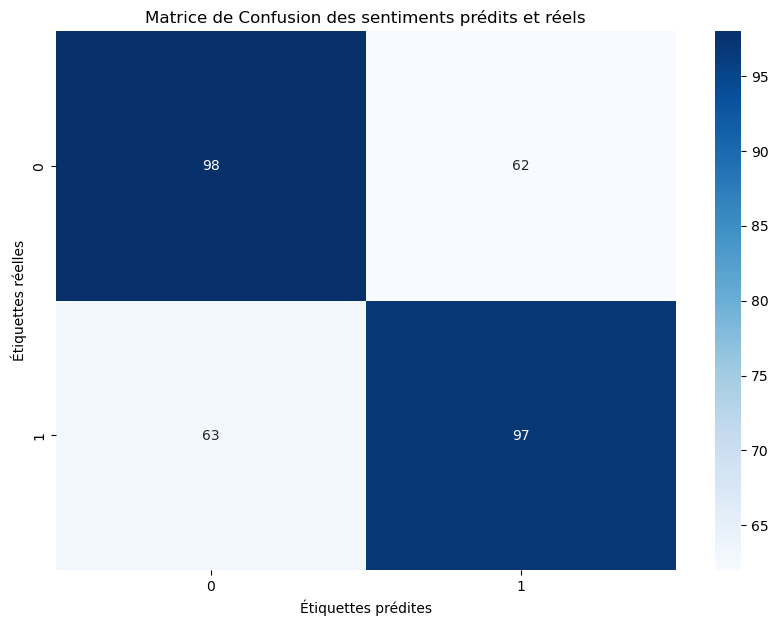

In [18]:
# Exécution du modèle avec la fonction reg_log_fct
print("Word2Vec : ")
print("-----------------")
accuracy_w2v, precision_w2v, report_w2v, exec_time_w2v, model_w2v, X_train_w2v = reg_log_fct(embeddings, labels)

Word2Vec : 
-----------------
Accuracy : 0.65
Precision : 0.6643835616438356
Classification Report :


,precision,recall,f1-score,support
0,0.637931,0.69375,0.664671,160.00
1,0.664384,0.60625,0.633987,160.00
accuracy,0.650000,0.65000,0.650000,0.65
macro avg,0.651157,0.65000,0.649329,320.00
weighted avg,0.651157,0.65000,0.649329,320.00


Temps d'exécution : 0.94 secondes


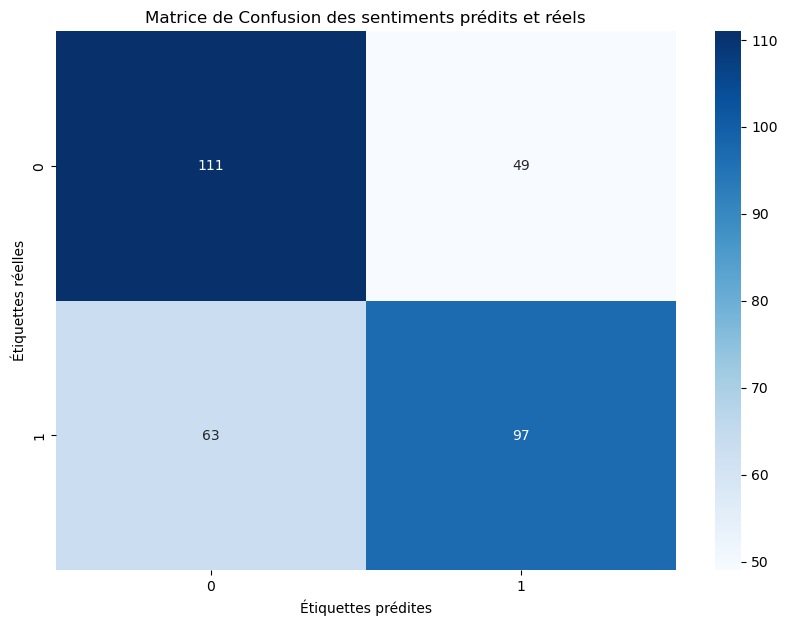

In [19]:
# Exécution du modèle avec la fonction rand_for_fct
print("Word2Vec : ")
print("-----------------")
accuracy_w2v_rf, precision_w2v_rf, report_w2v_rf, exec_time_w2v_rf, model_w2v_rf, X_train_w2v_rf = rand_for_fct(embeddings, labels)

Word2Vec : 
-----------------
Accuracy : 0.61875
Precision : 0.6233766233766234
Classification Report :


,precision,recall,f1-score,support
0,0.614458,0.63750,0.625767,160.00000
1,0.623377,0.60000,0.611465,160.00000
accuracy,0.618750,0.61875,0.618750,0.61875
macro avg,0.618917,0.61875,0.618616,320.00000
weighted avg,0.618917,0.61875,0.618616,320.00000


Temps d'exécution : 0.12 secondes


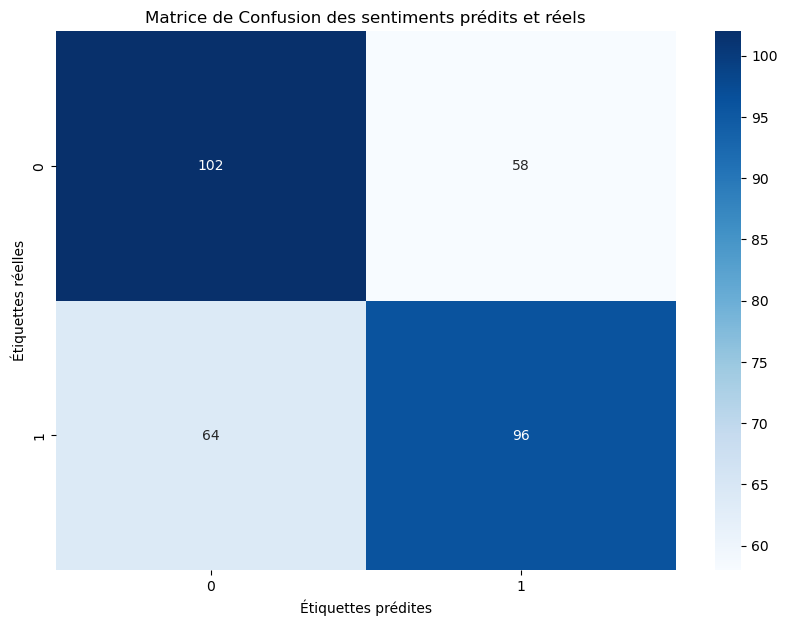

In [20]:
# Exécution du modèle avec la fonction svm_fct
print("Word2Vec : ")
print("-----------------")
accuracy_w2v_svm, precision_w2v_svm, report_w2v_svm, exec_time_w2v_svm, model_w2v_svm, X_train_w2v_svm = svm_fct(embeddings, labels)

Word2Vec : 
-----------------
Accuracy : 0.575
Precision : 0.5857142857142857
Classification Report :


,precision,recall,f1-score,support
0,0.566667,0.6375,0.600000,160.000
1,0.585714,0.5125,0.546667,160.000
accuracy,0.575000,0.5750,0.575000,0.575
macro avg,0.576190,0.5750,0.573333,320.000
weighted avg,0.576190,0.5750,0.573333,320.000


Temps d'exécution : 1.24 secondes


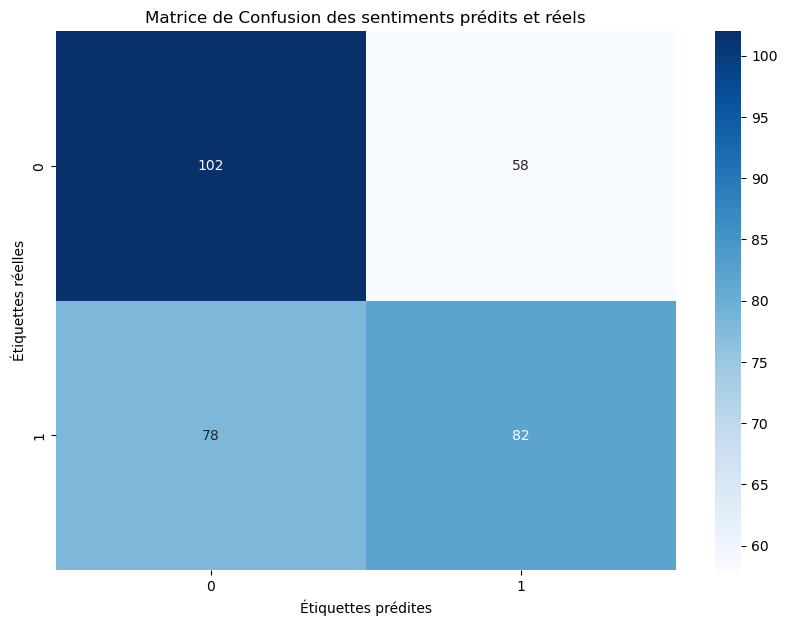

In [21]:
# Exécution du modèle avec la fonction xgb_fct
print("Word2Vec : ")
print("-----------------")
accuracy_w2v_xgb, precision_w2v_xgb, report_w2v_xgb, exec_time_w2v_xgb, model_w2v_xgb, X_train_w2v_xgb = xgb_fct(embeddings, labels)

#### b - FastText

In [22]:
# Paramètres
ft_size = 300  # Taille des vecteurs
ft_window = 5  # Fenêtre de contexte
ft_min_count = 1  # Ignore les mots qui apparaissent moins de ce nombre
ft_epochs = 100  # Nombre d'époques d'entraînement
ft_workers = 4  # Nombre de threads

# Préparation des données
sentences = echantillon_tweet["tweet"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [23]:
# Création et entraînement du modèle FastText
print("Entraînement du modèle FastText...")
ft_model = FastText(
    vector_size=ft_size,
    window=ft_window,
    min_count=ft_min_count,
    workers=ft_workers,
    sg=1,  # Skip-gram (mettez sg=0 pour CBOW si nécessaire)
    seed=42
)
ft_model.build_vocab(sentences)
ft_model.train(sentences, total_examples=len(sentences), epochs=ft_epochs)

# Accès aux vecteurs
model_vectors = ft_model.wv
ft_words = model_vectors.index_to_key
print("Taille du vocabulaire : %i" % len(ft_words))
print("FastText entraîné.")

Entraînement du modèle FastText...
Taille du vocabulaire : 3725
FastText entraîné.


In [24]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Nombre de mots uniques : %i" % num_words)

Fit Tokenizer ...
Nombre de mots uniques : 3726


In [25]:
print("Création de la matrice d'embedding ...")

ft_size = 300  # Taille des vecteurs (comme défini dans FastText)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, ft_size))
i = 0
j = 0

# Ajout des vecteurs FastText dans la matrice d'embedding
for word, idx in word_index.items():
    i += 1
    if word in ft_model.wv:  # Vérifie si le mot existe dans le vocabulaire FastText
        j += 1
        embedding_vector = ft_model.wv[word]  # Récupère le vecteur du mot
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

# Calcul du taux de couverture des mots dans l'embedding
word_rate = np.round(j / i, 4)
print("Taux Word embedding : ", word_rate)
print("Matrice d'Embedding: %s" % str(embedding_matrix.shape))

Création de la matrice d'embedding ...
Taux Word embedding :  1.0
Matrice d'Embedding: (3726, 300)


In [26]:
# Création du modèle
input = Input(shape=(maxlen,), dtype='int32')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=ft_size,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False)(input)  # On laisse les vecteurs FastText fixes
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model(input, word_vec)

embed_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 50, 300)        │     1,117,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,800 (4.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,117,800 (4.26 MB)

In [27]:
embeddings_ft = embed_model.predict(x_sentences)
print(embeddings_ft.shape)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
(1600, 300)


FastText : 
-----------------
Accuracy : 0.603125
Precision : 0.5976331360946746
Classification Report :


,precision,recall,f1-score,support
0,0.609272,0.575000,0.591640,160.000000
1,0.597633,0.631250,0.613982,160.000000
accuracy,0.603125,0.603125,0.603125,0.603125
macro avg,0.603452,0.603125,0.602811,320.000000
weighted avg,0.603452,0.603125,0.602811,320.000000


Temps d'exécution : 0.0 secondes


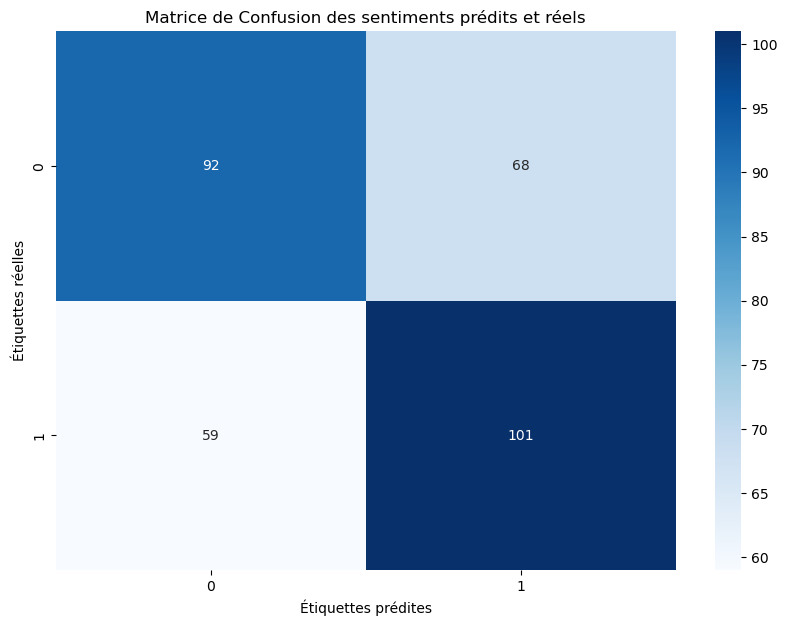

In [28]:
# Exécution du modèle avec la fonction reg_log_fct
print("FastText : ")
print("-----------------")
accuracy_ft, precision_ft, report_ft, exec_time_ft, model_ft, X_train_ft = reg_log_fct(embeddings_ft, labels)

FastText : 
-----------------
Accuracy : 0.640625
Precision : 0.6470588235294118
Classification Report :


,precision,recall,f1-score,support
0,0.634731,0.662500,0.648318,160.000000
1,0.647059,0.618750,0.632588,160.000000
accuracy,0.640625,0.640625,0.640625,0.640625
macro avg,0.640895,0.640625,0.640453,320.000000
weighted avg,0.640895,0.640625,0.640453,320.000000


Temps d'exécution : 0.93 secondes


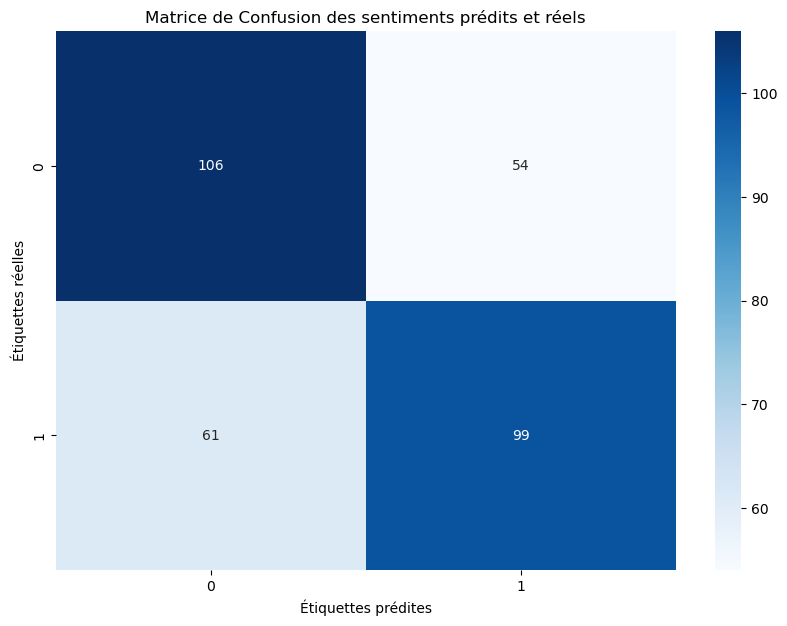

In [29]:
# Exécution du modèle avec la fonction rand_for_fct
print("FastText : ")
print("-----------------")
accuracy_ft_rf, precision_ft_rf, report_ft_rf, exec_time_ft_rf, model_ft_rf, X_train_ft_rf = rand_for_fct(embeddings_ft, labels)

FastText : 
-----------------
Accuracy : 0.584375
Precision : 0.5714285714285714
Classification Report :


,precision,recall,f1-score,support
0,0.603053,0.493750,0.542955,160.000000
1,0.571429,0.675000,0.618911,160.000000
accuracy,0.584375,0.584375,0.584375,0.584375
macro avg,0.587241,0.584375,0.580933,320.000000
weighted avg,0.587241,0.584375,0.580933,320.000000


Temps d'exécution : 0.11 secondes


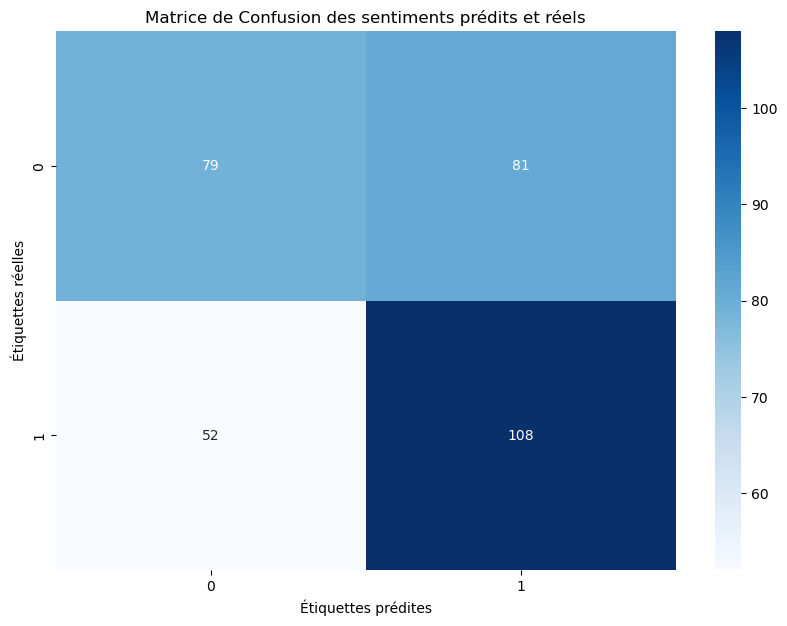

In [30]:
# Exécution du modèle avec la fonction svm_fct
print("FastText : ")
print("-----------------")
accuracy_ft_svm, precision_ft_svm, report_ft_svm, exec_time_ft_svm, model_ft_svm, X_train_ft_svm = svm_fct(embeddings_ft, labels)

FastText : 
-----------------
Accuracy : 0.60625
Precision : 0.6049382716049383
Classification Report :


,precision,recall,f1-score,support
0,0.607595,0.60000,0.603774,160.00000
1,0.604938,0.61250,0.608696,160.00000
accuracy,0.606250,0.60625,0.606250,0.60625
macro avg,0.606267,0.60625,0.606235,320.00000
weighted avg,0.606267,0.60625,0.606235,320.00000


Temps d'exécution : 0.85 secondes


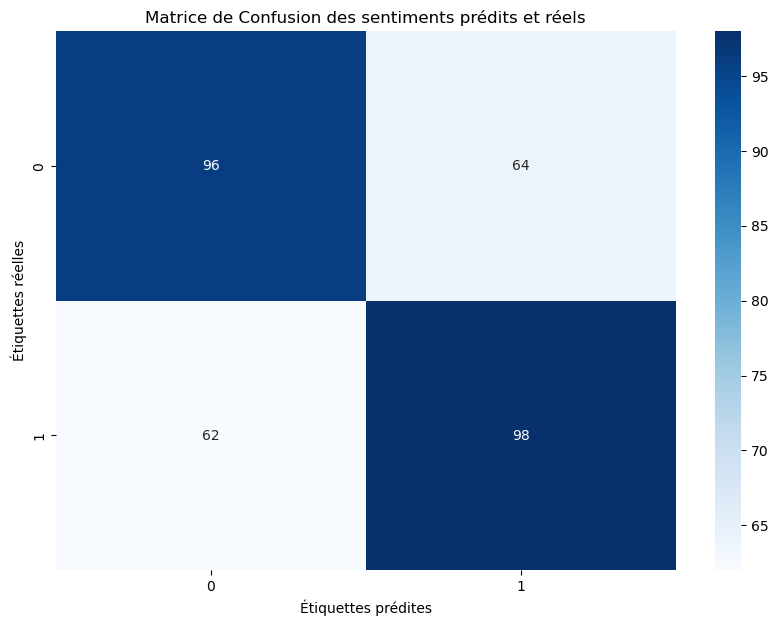

In [31]:
# Exécution du modèle avec la fonction xgb_fct
print("FastText : ")
print("-----------------")
accuracy_ft_xgb, precision_ft_xgb, report_ft_xgb, exec_time_ft_xgb, model_ft_xgb, X_train_ft_xgb = xgb_fct(embeddings_ft, labels)

### 2 - BERT

#### a - Fonctions communes

In [32]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### b - HuggingFace 'bert-base-uncased'

In [33]:
# Paramètres
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = echantillon_tweet["tweet"].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [34]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 185ms/step
temps traitement :  41.0


BERT HuggingFace : 
-----------------
Accuracy : 0.678125
Precision : 0.6993006993006993
Classification Report :


,precision,recall,f1-score,support
0,0.661017,0.731250,0.694362,160.000000
1,0.699301,0.625000,0.660066,160.000000
accuracy,0.678125,0.678125,0.678125,0.678125
macro avg,0.680159,0.678125,0.677214,320.000000
weighted avg,0.680159,0.678125,0.677214,320.000000


Temps d'exécution : 0.06 secondes


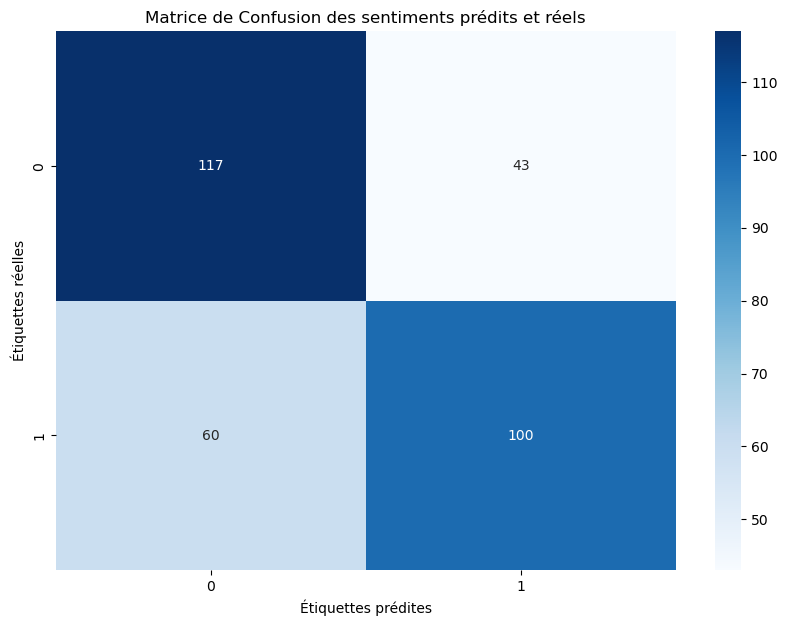

In [35]:
# Exécution du modèle avec la fonction reg_log_fct
print("BERT HuggingFace : ")
print("-----------------")
accuracy_bhf, precision_bhf, report_bhf, exec_time_bhf, model_bhf, X_train_bhf = reg_log_fct(features_bert, labels)

BERT HuggingFace : 
-----------------
Accuracy : 0.6875
Precision : 0.6829268292682927
Classification Report :


,precision,recall,f1-score,support
0,0.692308,0.6750,0.683544,160.0000
1,0.682927,0.7000,0.691358,160.0000
accuracy,0.687500,0.6875,0.687500,0.6875
macro avg,0.687617,0.6875,0.687451,320.0000
weighted avg,0.687617,0.6875,0.687451,320.0000


Temps d'exécution : 1.44 secondes


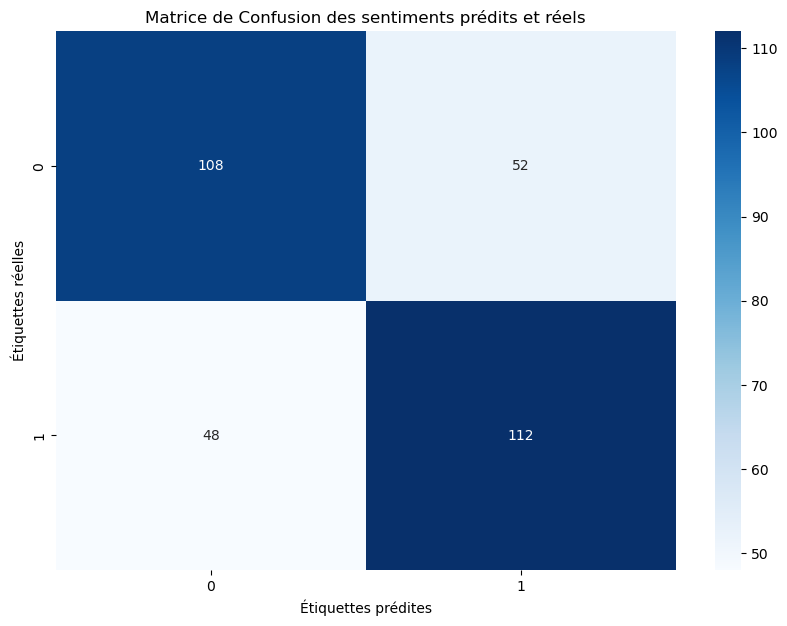

In [36]:
# Exécution du modèle avec la fonction rand_for_fct
print("BERT HuggingFace : ")
print("-----------------")
accuracy_bhf_rf, precision_bhf_rf, report_bhf_rf, exec_time_bhf_rf, model_bhf_rf, X_train_bhf_rf = rand_for_fct(features_bert, labels)

BERT HuggingFace : 
-----------------
Accuracy : 0.65625
Precision : 0.676056338028169
Classification Report :


,precision,recall,f1-score,support
0,0.640449,0.71250,0.674556,160.00000
1,0.676056,0.60000,0.635762,160.00000
accuracy,0.656250,0.65625,0.656250,0.65625
macro avg,0.658253,0.65625,0.655159,320.00000
weighted avg,0.658253,0.65625,0.655159,320.00000


Temps d'exécution : 0.22 secondes


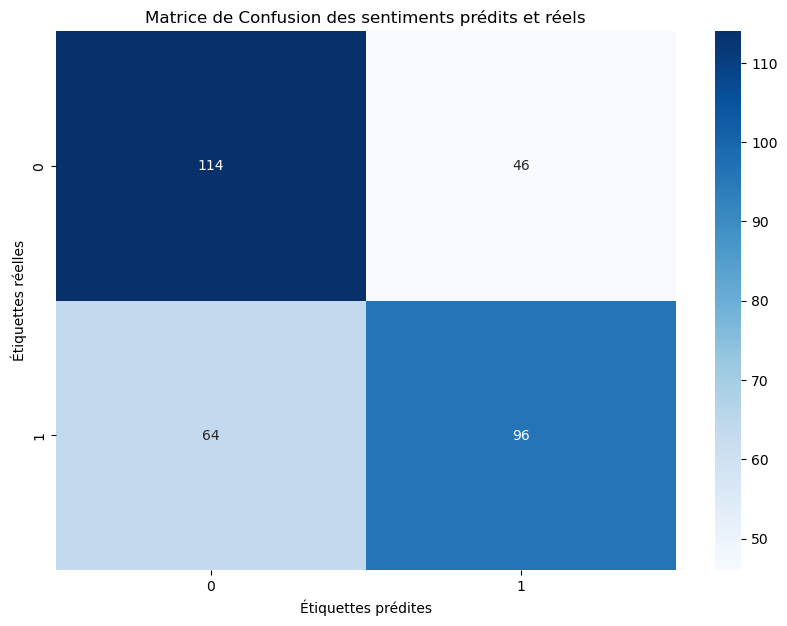

In [37]:
# Exécution du modèle avec la fonction svm_fct
print("BERT HuggingFace : ")
print("-----------------")
accuracy_bhf_svm, precision_bhf_svm, report_bhf_svm, exec_time_bhf_svm, model_bhf_svm, X_train_bhf_svm = svm_fct(features_bert, labels)

BERT HuggingFace : 
-----------------
Accuracy : 0.696875
Precision : 0.6981132075471698
Classification Report :


,precision,recall,f1-score,support
0,0.695652,0.700000,0.697819,160.000000
1,0.698113,0.693750,0.695925,160.000000
accuracy,0.696875,0.696875,0.696875,0.696875
macro avg,0.696883,0.696875,0.696872,320.000000
weighted avg,0.696883,0.696875,0.696872,320.000000


Temps d'exécution : 1.7 secondes


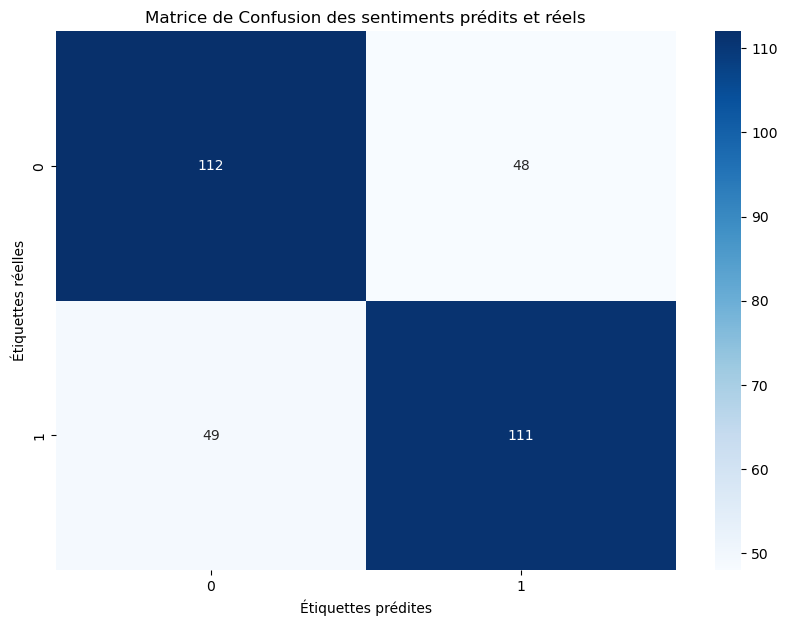

In [38]:
# Exécution du modèle avec la fonction xgb_fct
print("BERT HuggingFace : ")
print("-----------------")
accuracy_bhf_xgb, precision_bhf_xgb, report_bhf_xgb, exec_time_bhf_xgb, model_bhf_xgb, X_train_bhf_xgb = xgb_fct(features_bert, labels)

#### c - HuggingFace 'cardiffnlp/twitter-roberta-base-sentiment'

In [39]:
# Paramètres
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = echantillon_tweet["tweet"].to_list()

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [40]:
features_bert_tw, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 191ms/step
temps traitement :  40.0


BERT HuggingFace Tweet : 
-----------------
Accuracy : 0.715625
Precision : 0.7346938775510204
Classification Report :


,precision,recall,f1-score,support
0,0.699422,0.756250,0.726727,160.000000
1,0.734694,0.675000,0.703583,160.000000
accuracy,0.715625,0.715625,0.715625,0.715625
macro avg,0.717058,0.715625,0.715155,320.000000
weighted avg,0.717058,0.715625,0.715155,320.000000


Temps d'exécution : 0.13 secondes


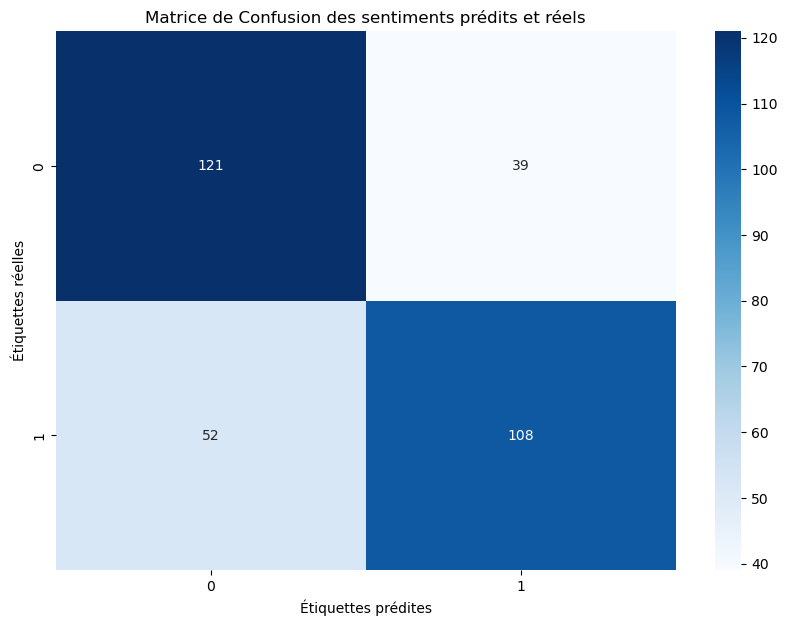

In [41]:
# Exécution du modèle avec la fonction reg_log_fct
print("BERT HuggingFace Tweet : ")
print("-----------------")
accuracy_btw, precision_btw, report_btw, exec_time_btw, model_btw, X_train_btw = reg_log_fct(features_bert_tw, labels)

BERT HuggingFace Tweet : 
-----------------
Accuracy : 0.71875
Precision : 0.6988636363636364
Classification Report :


,precision,recall,f1-score,support
0,0.743056,0.66875,0.703947,160.00000
1,0.698864,0.76875,0.732143,160.00000
accuracy,0.718750,0.71875,0.718750,0.71875
macro avg,0.720960,0.71875,0.718045,320.00000
weighted avg,0.720960,0.71875,0.718045,320.00000


Temps d'exécution : 1.5 secondes


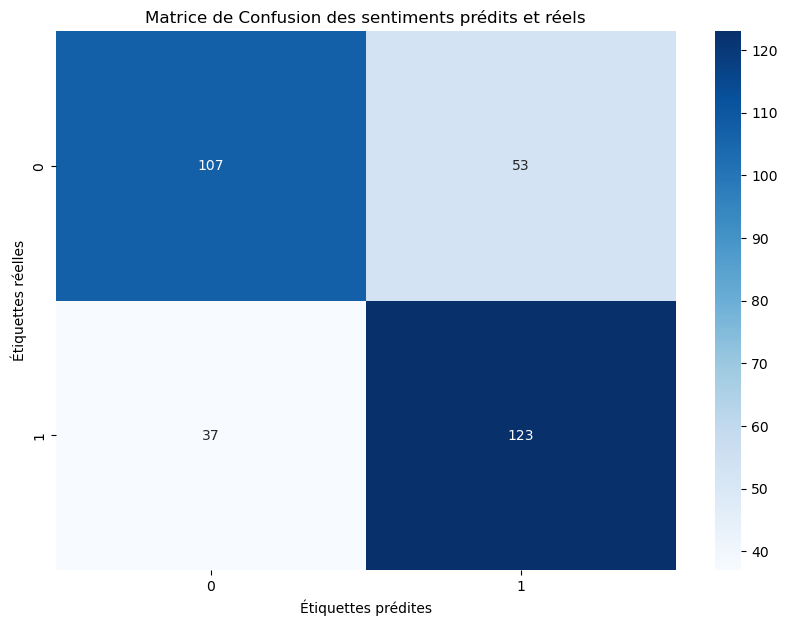

In [42]:
# Exécution du modèle avec la fonction rand_for_fct
print("BERT HuggingFace Tweet : ")
print("-----------------")
accuracy_btw_rf, precision_btw_rf, report_btw_rf, exec_time_btw_rf, model_btw_rf, X_train_btw_rf = rand_for_fct(features_bert_tw, labels)

BERT HuggingFace Tweet : 
-----------------
Accuracy : 0.684375
Precision : 0.7006802721088435
Classification Report :


,precision,recall,f1-score,support
0,0.670520,0.725000,0.696697,160.000000
1,0.700680,0.643750,0.671010,160.000000
accuracy,0.684375,0.684375,0.684375,0.684375
macro avg,0.685600,0.684375,0.683853,320.000000
weighted avg,0.685600,0.684375,0.683853,320.000000


Temps d'exécution : 0.31 secondes


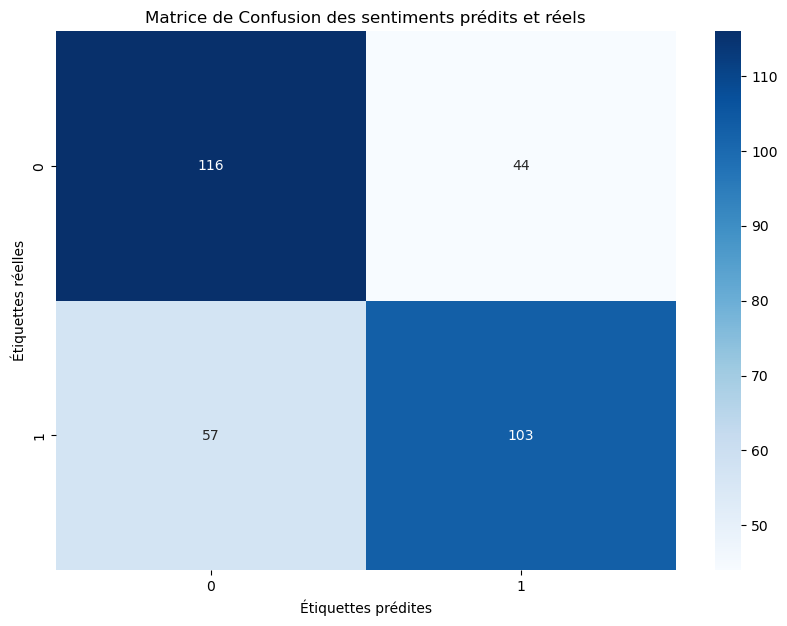

In [43]:
# Exécution du modèle avec la fonction svm_fct
print("BERT HuggingFace Tweet : ")
print("-----------------")
accuracy_btw_svm, precision_btw_svm, report_btw_svm, exec_time_btw_svm, model_btw_svm, X_train_btw_svm = svm_fct(features_bert_tw, labels)

BERT HuggingFace Tweet : 
-----------------
Accuracy : 0.715625
Precision : 0.7041420118343196
Classification Report :


,precision,recall,f1-score,support
0,0.728477,0.687500,0.707395,160.000000
1,0.704142,0.743750,0.723404,160.000000
accuracy,0.715625,0.715625,0.715625,0.715625
macro avg,0.716309,0.715625,0.715400,320.000000
weighted avg,0.716309,0.715625,0.715400,320.000000


Temps d'exécution : 1.43 secondes


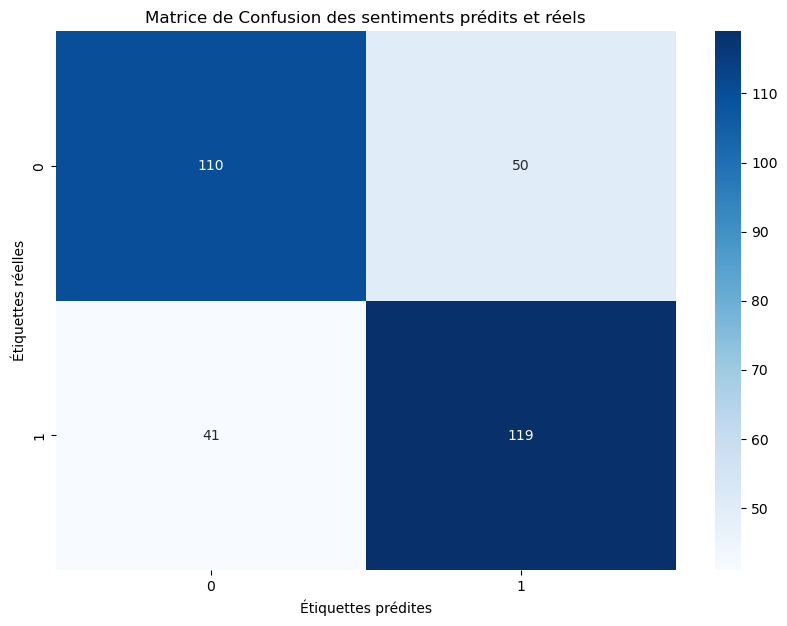

In [44]:
# Exécution du modèle avec la fonction reg_log_fct
print("BERT HuggingFace Tweet : ")
print("-----------------")
accuracy_btw_xgb, precision_btw_xgb, report_btw_xgb, exec_time_btw_xgb, model_btw_xgb, X_train_btw_xgb = xgb_fct(features_bert_tw, labels)

## 3 - USE

In [45]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    # Stocker les résultats dans une liste
    features_list = []

    for step in range(len(sentences) // batch_size):
        start = time.time()
        idx = step * batch_size
        feat = embed(sentences[idx:idx + batch_size])  # Extraction des features
        features_list.append(feat)
        print(f"Batch {step + 1}/{len(sentences) // batch_size} traité en {time.time() - start:.2f} secondes")

    # Concaténation finale
    features = np.vstack(features_list)  # Plus efficace qu'une concaténation répétée

    time2 = np.round(time.time() - time1, 0)
    print(f"Extraction terminée en {time2} secondes")
    return features

In [47]:
# Paramètres
batch_size = 10
sentences = echantillon_tweet["tweet"].to_list()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [48]:
# Création des features à partir de la fonction USE
features_USE = feature_USE_fct(sentences, batch_size)

Batch 1/160 traité en 0.21 secondes
Batch 2/160 traité en 0.00 secondes
Batch 3/160 traité en 0.00 secondes
Batch 4/160 traité en 0.00 secondes
Batch 5/160 traité en 0.01 secondes
Batch 6/160 traité en 0.00 secondes
Batch 7/160 traité en 0.00 secondes
Batch 8/160 traité en 0.00 secondes
Batch 9/160 traité en 0.00 secondes
Batch 10/160 traité en 0.00 secondes
Batch 11/160 traité en 0.00 secondes
Batch 12/160 traité en 0.00 secondes
Batch 13/160 traité en 0.00 secondes
Batch 14/160 traité en 0.00 secondes
Batch 15/160 traité en 0.00 secondes
Batch 16/160 traité en 0.00 secondes
Batch 17/160 traité en 0.00 secondes
Batch 18/160 traité en 0.00 secondes
Batch 19/160 traité en 0.00 secondes
Batch 20/160 traité en 0.00 secondes
Batch 21/160 traité en 0.00 secondes
Batch 22/160 traité en 0.00 secondes
Batch 23/160 traité en 0.00 secondes
Batch 24/160 traité en 0.00 secondes
Batch 25/160 traité en 0.00 secondes
Batch 26/160 traité en 0.00 secondes
Batch 27/160 traité en 0.00 secondes
Batch 28/1

USE : 
-----------------
Accuracy : 0.75
Precision : 0.7857142857142857
Classification Report :


,precision,recall,f1-score,support
0,0.722222,0.8125,0.764706,160.00
1,0.785714,0.6875,0.733333,160.00
accuracy,0.750000,0.7500,0.750000,0.75
macro avg,0.753968,0.7500,0.749020,320.00
weighted avg,0.753968,0.7500,0.749020,320.00


Temps d'exécution : 0.01 secondes


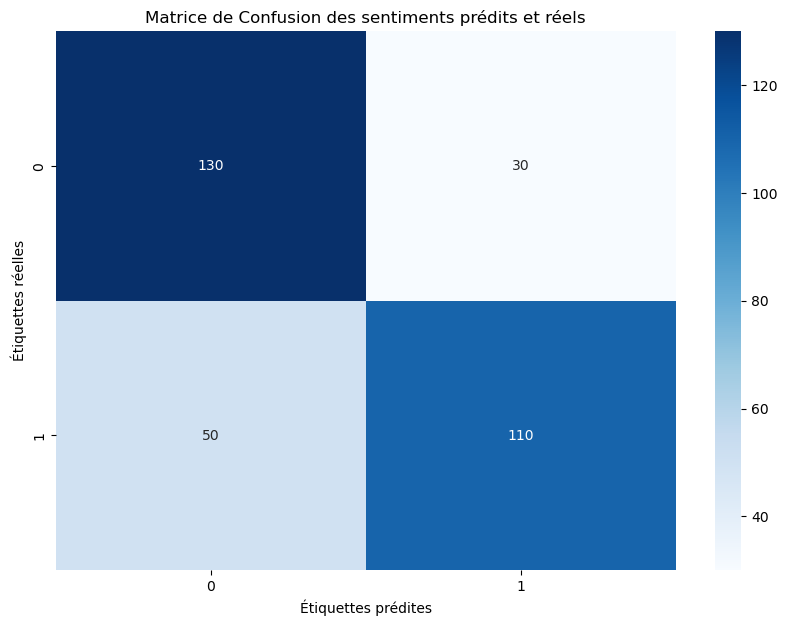

In [49]:
# Exécution du modèle avec la fonction reg_log_fct
print("USE : ")
print("-----------------")
accuracy_use, precision_use, report_use, exec_time_use, model_use, X_train_use = reg_log_fct(features_USE, labels)

USE : 
-----------------
Accuracy : 0.703125
Precision : 0.7181208053691275
Classification Report :


,precision,recall,f1-score,support
0,0.690058,0.737500,0.712991,160.000000
1,0.718121,0.668750,0.692557,160.000000
accuracy,0.703125,0.703125,0.703125,0.703125
macro avg,0.704090,0.703125,0.702774,320.000000
weighted avg,0.704090,0.703125,0.702774,320.000000


Temps d'exécution : 1.25 secondes


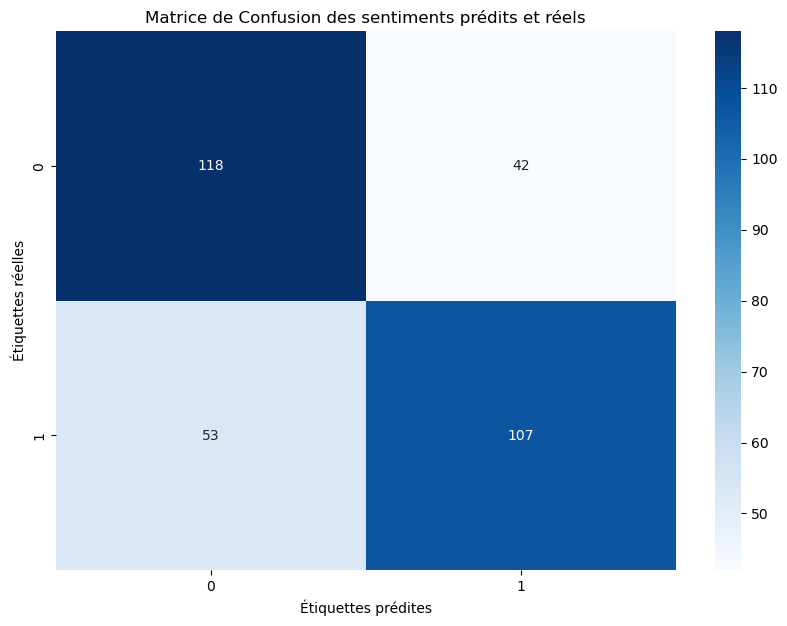

In [50]:
# Exécution du modèle avec la fonction rand_for_fct
print("USE : ")
print("-----------------")
accuracy_use_rf, precision_use_rf, report_use_rf, exec_time_use_rf, model_use_rf, X_train_use_rf = rand_for_fct(features_USE, labels)

USE : 
-----------------
Accuracy : 0.75
Precision : 0.7777777777777778
Classification Report :


,precision,recall,f1-score,support
0,0.727273,0.80,0.761905,160.00
1,0.777778,0.70,0.736842,160.00
accuracy,0.750000,0.75,0.750000,0.75
macro avg,0.752525,0.75,0.749373,320.00
weighted avg,0.752525,0.75,0.749373,320.00


Temps d'exécution : 0.12 secondes


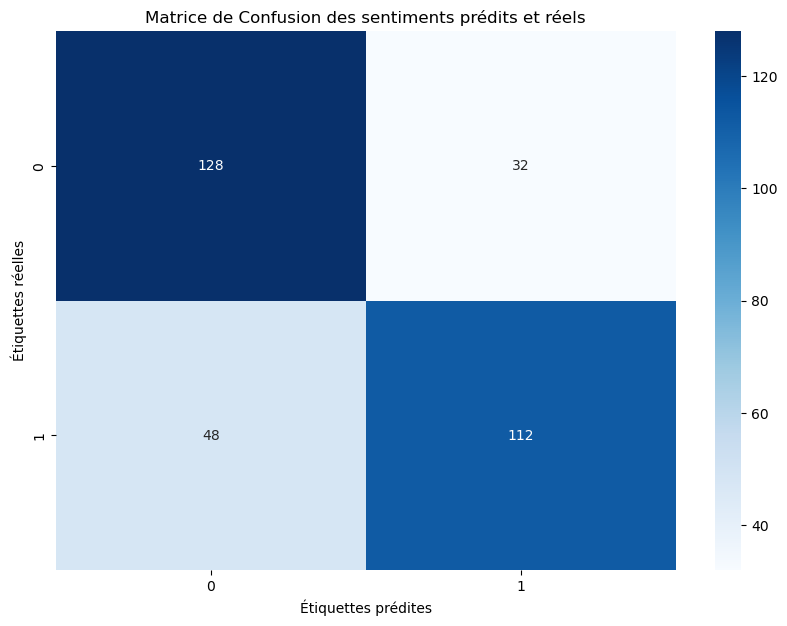

In [51]:
# Exécution du modèle avec la fonction reg_log_fct
print("USE : ")
print("-----------------")
accuracy_use_svm, precision_use_svm, report_use_svm, exec_time_use_svm, model_use_svm, X_train_use_svm = svm_fct(features_USE, labels)

USE : 
-----------------
Accuracy : 0.725
Precision : 0.7337662337662337
Classification Report :


,precision,recall,f1-score,support
0,0.716867,0.74375,0.730061,160.000
1,0.733766,0.70625,0.719745,160.000
accuracy,0.725000,0.72500,0.725000,0.725
macro avg,0.725317,0.72500,0.724903,320.000
weighted avg,0.725317,0.72500,0.724903,320.000


Temps d'exécution : 1.14 secondes


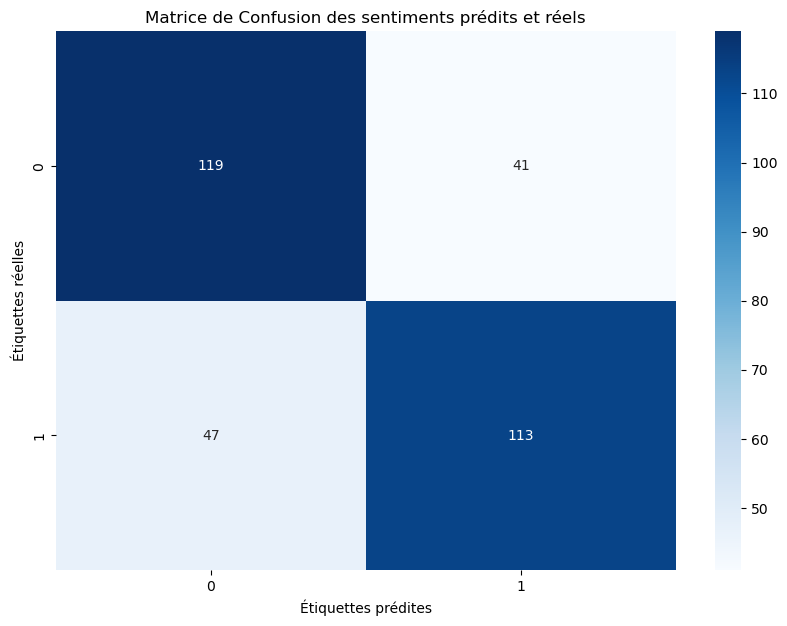

In [52]:
# Exécution du modèle avec la fonction xgb_fct
print("USE : ")
print("-----------------")
accuracy_use_xgb, precision_use_xgb, report_use_xgb, exec_time_use_xgb, model_use_xgb, X_train_use_xgb = xgb_fct(features_USE, labels)

## III - Tracking
### 1 - Embedding
#### a - Word2Vec

In [53]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_w2v)
    mlflow.log_metric("Precision", precision_w2v)
    mlflow.log_metric("Temps", exec_time_w2v)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "Word2Vec")
    mlflow.set_tag("Model", "Régression Logistique")

    # Infer the model signature
    signature = infer_signature(X_train_w2v, model_w2v.predict(X_train_w2v))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_w2v,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_w2v,
        registered_model_name="Word2Vec_RegLog",
    )

2024/12/19 12:59:11 INFO mlflow.tracking.fluent: Experiment with name 'Projet 7 - Réseaux de neurones' does not exist. Creating a new experiment.


Successfully registered model 'Word2Vec_RegLog'.
2024/12/19 12:59:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Word2Vec_RegLog, version 1


🏃 View run kindly-shrew-210 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/ae3f7a00f4884e0fa07c7b561fb1dbdf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'Word2Vec_RegLog'.


In [54]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rf)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_w2v_rf)
    mlflow.log_metric("Precision", precision_w2v_rf)
    mlflow.log_metric("Temps", exec_time_w2v_rf)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "Word2Vec")
    mlflow.set_tag("Model", "Random Forest")

    # Infer the model signature
    signature = infer_signature(X_train_w2v_rf, model_w2v_rf.predict(X_train_w2v_rf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_w2v_rf,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_w2v_rf,
        registered_model_name="Word2Vec_RandFor",
    )

Successfully registered model 'Word2Vec_RandFor'.
2024/12/19 12:59:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Word2Vec_RandFor, version 1


🏃 View run auspicious-kite-933 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/114ec49d044849f3a942edcab57fa9ed
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'Word2Vec_RandFor'.


In [55]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_svm)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_w2v_svm)
    mlflow.log_metric("Precision", precision_w2v_svm)
    mlflow.log_metric("Temps", exec_time_w2v_svm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "Word2Vec")
    mlflow.set_tag("Model", "SVM")

    # Infer the model signature
    signature = infer_signature(X_train_w2v_svm, model_w2v_svm.predict(X_train_w2v_svm))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_w2v_svm,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_w2v_svm,
        registered_model_name="Word2Vec_SVM",
    )

Successfully registered model 'Word2Vec_SVM'.
2024/12/19 12:59:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Word2Vec_SVM, version 1


🏃 View run intrigued-stork-990 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/48d1b212076849c6892eeba6fd3ecd6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'Word2Vec_SVM'.


In [56]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_xgb)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_w2v_xgb)
    mlflow.log_metric("Precision", precision_w2v_xgb)
    mlflow.log_metric("Temps", exec_time_w2v_xgb)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "Word2Vec")
    mlflow.set_tag("Model", "XGBoost")

    # Infer the model signature
    signature = infer_signature(X_train_w2v_xgb, model_w2v_xgb.predict(X_train_w2v_xgb))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_w2v_xgb,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_w2v_xgb,
        registered_model_name="Word2Vec_XGB",
    )

Successfully registered model 'Word2Vec_XGB'.
2024/12/19 12:59:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Word2Vec_XGB, version 1


🏃 View run orderly-grouse-385 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/ac254ef617264871a3c0fee4df82fe33
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'Word2Vec_XGB'.


#### b - FastText

In [57]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_ft)
    mlflow.log_metric("Precision", precision_ft)
    mlflow.log_metric("Temps", exec_time_ft)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "FastText")
    mlflow.set_tag("Model", "Régression Logistique")

    # Infer the model signature
    signature = infer_signature(X_train_ft, model_ft.predict(X_train_ft))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_ft,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_ft,
        registered_model_name="FastText_RegLog",
    )

Successfully registered model 'FastText_RegLog'.
2024/12/19 12:59:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FastText_RegLog, version 1


🏃 View run clumsy-fox-799 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/0e5a46c09fd243588ec7bc97ca06003e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'FastText_RegLog'.


In [58]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rf)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_ft_rf)
    mlflow.log_metric("Precision", precision_ft_rf)
    mlflow.log_metric("Temps", exec_time_ft_rf)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "FastText")
    mlflow.set_tag("Model", "Random Forest")

    # Infer the model signature
    signature = infer_signature(X_train_ft_rf, model_ft_rf.predict(X_train_ft_rf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_ft_rf,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_ft_rf,
        registered_model_name="FastText_RandFor",
    )

Successfully registered model 'FastText_RandFor'.
2024/12/19 13:00:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FastText_RandFor, version 1


🏃 View run caring-roo-465 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/c2ef938598f1443798c2666ea5ad1e51
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'FastText_RandFor'.


In [59]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_svm)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_ft_svm)
    mlflow.log_metric("Precision", precision_ft_svm)
    mlflow.log_metric("Temps", exec_time_ft_svm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "FastText")
    mlflow.set_tag("Model", "SVM")

    # Infer the model signature
    signature = infer_signature(X_train_ft_svm, model_ft_svm.predict(X_train_ft_svm))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_ft_svm,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_ft_svm,
        registered_model_name="FastText_SVM",
    )

Successfully registered model 'FastText_SVM'.
2024/12/19 13:00:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FastText_SVM, version 1


🏃 View run receptive-deer-614 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/a0f20eb389db4498b74bf716923a7dba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'FastText_SVM'.


In [60]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_xgb)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_ft_xgb)
    mlflow.log_metric("Precision", precision_ft_xgb)
    mlflow.log_metric("Temps", exec_time_ft_xgb)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "FastText")
    mlflow.set_tag("Model", "XGBoost")

    # Infer the model signature
    signature = infer_signature(X_train_ft_xgb, model_ft_xgb.predict(X_train_ft_xgb))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_ft_xgb,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_ft_xgb,
        registered_model_name="FastText_XGB",
    )

Successfully registered model 'FastText_XGB'.
2024/12/19 13:00:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FastText_XGB, version 1


🏃 View run melodic-bee-26 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/83dbf9f5a25a41f39d2e88595588c85e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'FastText_XGB'.


### 2 - BERT
#### a - HuggingFace Base

In [61]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_bhf)
    mlflow.log_metric("Precision", precision_bhf)
    mlflow.log_metric("Temps", exec_time_bhf)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Base")
    mlflow.set_tag("Model", "Régression Logistique")

    # Infer the model signature
    signature = infer_signature(X_train_bhf, model_bhf.predict(X_train_bhf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_bhf,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_bhf,
        registered_model_name="BERT_base_RegLog",
    )

Successfully registered model 'BERT_base_RegLog'.
2024/12/19 13:00:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_base_RegLog, version 1


🏃 View run nosy-chimp-182 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/5e56dd2c77b6406baa1a0d29af0c9e1b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_base_RegLog'.


In [62]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rf)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_bhf_rf)
    mlflow.log_metric("Precision", precision_bhf_rf)
    mlflow.log_metric("Temps", exec_time_bhf_rf)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Base")
    mlflow.set_tag("Model", "Random Forest")

    # Infer the model signature
    signature = infer_signature(X_train_bhf_rf, model_bhf_rf.predict(X_train_bhf_rf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_bhf_rf,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_bhf_rf,
        registered_model_name="BERT_base_RandFor",
    )

Successfully registered model 'BERT_base_RandFor'.
2024/12/19 13:00:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_base_RandFor, version 1


🏃 View run receptive-bass-625 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/6b3c026ad48a45e680ad63ff911552b4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_base_RandFor'.


In [63]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_svm)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_bhf_svm)
    mlflow.log_metric("Precision", precision_bhf_svm)
    mlflow.log_metric("Temps", exec_time_bhf_svm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Base")
    mlflow.set_tag("Model", "SVM")

    # Infer the model signature
    signature = infer_signature(X_train_bhf_svm, model_bhf_svm.predict(X_train_bhf_svm))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_bhf_svm,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_bhf_svm,
        registered_model_name="BERT_base_SVM",
    )

Successfully registered model 'BERT_base_SVM'.
2024/12/19 13:00:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_base_SVM, version 1


🏃 View run amazing-asp-416 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/0aa16263790d46b0a177d109dad81ac8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_base_SVM'.


In [64]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_xgb)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_bhf_xgb)
    mlflow.log_metric("Precision", precision_bhf_xgb)
    mlflow.log_metric("Temps", exec_time_bhf_xgb)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Base")
    mlflow.set_tag("Model", "XGBoost")

    # Infer the model signature
    signature = infer_signature(X_train_bhf_xgb, model_bhf_xgb.predict(X_train_bhf_xgb))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_bhf_xgb,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_bhf_xgb,
        registered_model_name="BERT_base_XGB",
    )

Successfully registered model 'BERT_base_XGB'.
2024/12/19 13:00:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_base_XGB, version 1


🏃 View run zealous-perch-902 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/7bfb2678b4394e7f98aaa853b5a6c0bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_base_XGB'.


#### b - HuggingFace Tweet

In [65]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_btw)
    mlflow.log_metric("Precision", precision_btw)
    mlflow.log_metric("Temps", exec_time_btw)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Tweet")
    mlflow.set_tag("Model", "Régression Logistique")

    # Infer the model signature
    signature = infer_signature(X_train_btw, model_btw.predict(X_train_btw))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_btw,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_btw,
        registered_model_name="BERT_tweet_RegLog",
    )

Successfully registered model 'BERT_tweet_RegLog'.
2024/12/19 13:01:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_tweet_RegLog, version 1


🏃 View run calm-perch-537 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/e34d5424c371459491a25988eb1b297a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_tweet_RegLog'.


In [66]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rf)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_btw_rf)
    mlflow.log_metric("Precision", precision_btw_rf)
    mlflow.log_metric("Temps", exec_time_btw_rf)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Tweet")
    mlflow.set_tag("Model", "Random Forest")

    # Infer the model signature
    signature = infer_signature(X_train_btw_rf, model_btw_rf.predict(X_train_btw_rf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_btw_rf,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_btw_rf,
        registered_model_name="BERT_tweet_RandFor",
    )

Successfully registered model 'BERT_tweet_RandFor'.
2024/12/19 13:01:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_tweet_RandFor, version 1


🏃 View run overjoyed-hen-958 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/d977a75bf2f94feda0a808d59dee20c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_tweet_RandFor'.


In [67]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_svm)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_btw_svm)
    mlflow.log_metric("Precision", precision_btw_svm)
    mlflow.log_metric("Temps", exec_time_btw_svm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Tweet")
    mlflow.set_tag("Model", "SVM")

    # Infer the model signature
    signature = infer_signature(X_train_btw_svm, model_btw_svm.predict(X_train_btw_svm))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_btw_svm,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_btw_svm,
        registered_model_name="BERT_tweet_SVM",
    )

Successfully registered model 'BERT_tweet_SVM'.
2024/12/19 13:01:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_tweet_SVM, version 1


🏃 View run dapper-dog-199 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/2a72ca8cac2b4fafab3cf4641e2def08
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_tweet_SVM'.


In [68]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_xgb)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_btw_xgb)
    mlflow.log_metric("Precision", precision_btw_xgb)
    mlflow.log_metric("Temps", exec_time_btw_xgb)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "BERT Tweet")
    mlflow.set_tag("Model", "XGBoost")

    # Infer the model signature
    signature = infer_signature(X_train_btw_xgb, model_btw_xgb.predict(X_train_btw_xgb))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_btw_xgb,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_btw_xgb,
        registered_model_name="BERT_tweet_XGB",
    )

Successfully registered model 'BERT_tweet_XGB'.
2024/12/19 13:01:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BERT_tweet_XGB, version 1


🏃 View run intrigued-fish-49 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/c7975c226baa45d38412edc66c937356
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'BERT_tweet_XGB'.


### 3 - USE

In [69]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_use)
    mlflow.log_metric("Precision", precision_use)
    mlflow.log_metric("Temps", exec_time_use)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "USE")
    mlflow.set_tag("Model", "Régression Logistique")

    # Infer the model signature
    signature = infer_signature(X_train_use, model_use.predict(X_train_use))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_use,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_use,
        registered_model_name="USE_RegLog",
    )

Successfully registered model 'USE_RegLog'.
2024/12/19 13:01:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: USE_RegLog, version 1


🏃 View run redolent-bird-649 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/421cc675e75d48c8b24cba89fc1961c9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'USE_RegLog'.


In [70]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rf)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_use_rf)
    mlflow.log_metric("Precision", precision_use_rf)
    mlflow.log_metric("Temps", exec_time_use_rf)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "USE")
    mlflow.set_tag("Model", "Random Forest")

    # Infer the model signature
    signature = infer_signature(X_train_use_rf, model_use_rf.predict(X_train_use_rf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_use_rf,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_use_rf,
        registered_model_name="USE_RandFor",
    )

Successfully registered model 'USE_RandFor'.
2024/12/19 13:01:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: USE_RandFor, version 1


🏃 View run bedecked-deer-464 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/3dad7c43ba3a40b480978024dff6bb1e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'USE_RandFor'.


In [71]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_svm)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_use_svm)
    mlflow.log_metric("Precision", precision_use_svm)
    mlflow.log_metric("Temps", exec_time_use_svm)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "USE")
    mlflow.set_tag("Model", "SVM")

    # Infer the model signature
    signature = infer_signature(X_train_use_svm, model_use_svm.predict(X_train_use_svm))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_use_svm,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_use_svm,
        registered_model_name="USE_SVM",
    )

Successfully registered model 'USE_SVM'.
2024/12/19 13:02:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: USE_SVM, version 1


🏃 View run righteous-stoat-65 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/e52d8ad866ff47699552bdfd96221c3b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'USE_SVM'.


In [72]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Réseaux de neurones")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_xgb)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_use_xgb)
    mlflow.log_metric("Precision", precision_use_xgb)
    mlflow.log_metric("Temps", exec_time_use_xgb)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Algorithm", "USE")
    mlflow.set_tag("Model", "XGBoost")

    # Infer the model signature
    signature = infer_signature(X_train_use_xgb, model_use_xgb.predict(X_train_use_xgb))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_use_xgb,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_use_xgb,
        registered_model_name="USE_XGB",
    )

Successfully registered model 'USE_XGB'.
2024/12/19 13:02:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: USE_XGB, version 1


🏃 View run kindly-moose-55 at: http://127.0.0.1:5000/#/experiments/763084419985035195/runs/1ed7c2137bac4352a63aa69ade880836
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763084419985035195


Created version '1' of model 'USE_XGB'.


## Conclusion

In [80]:
# Enregistrement du meilleur modèle
dump(model_use, "best_model.joblib")

['best_model.joblib']